In [11]:
import os 
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [47]:
def get_remaining_players_repr(df, current_pick_num):
    default_adp = df['ADP'].max() + 10
    remaining_players = df[df['pick_num'] >= current_pick_num]
    remaining_players = remaining_players.sort_values('ADP')

    positions = ['QB', 'RB', 'WR', 'TE', 'DST', 'K']

    remaining_repr = {}
    for pos in positions:
        pos_players = remaining_players[remaining_players['player_pos'] == pos]
        pos_count = len(pos_players)
        pos_adp_values = pos_players['ADP'].nsmallest(3).tolist()

        # If less than 3 players, pad w/ default_adp (max + 10)
        while len(pos_adp_values) < 3:
            pos_adp_values.append(default_adp)

        remaining_repr[pos] = [pos_count] + pos_adp_values
    ret_df = pd.DataFrame(remaining_repr).T
    return ret_df.values

#Representation 2: Accounts for current roster of the team picking 

#Returns list of team's roster indicating position slots that can be filled 
# 0 = Slot filled 
def get_team_roster_repr(df, team_name, current_pick_num):
    df = df[df['pick_num'] < current_pick_num]
    team_df = df[df['team_name'] == team_name]

    positions = {'QB': 0, 'RB': 0, 'WR': 0, 'TE': 0, 'FLEX': 0, 'DST' : 0, 'K' : 0, 'Bench' : 0}
    starting_lineup = []
    bench = []
    team_df = team_df.sort_values('ADP')

    for index,row in team_df.iterrows():
            pos = row['player_pos']

            if ((pos in ['RB', 'WR'] and positions[pos] < 2) or
                (pos in ['QB', 'TE', 'DST', 'K'] and positions[pos] < 1)):
                positions[pos] += 1
            elif (pos == 'RB' and positions[pos] >= 2 and positions['FLEX'] < 1):
                positions['FLEX'] += 1

            elif (pos == 'WR' and positions[pos] >= 2 and positions['FLEX'] < 1):
                positions['FLEX'] += 1
            else:
                positions['Bench'] += 1

    curr_roster = [x for x in positions.values()]
    return np.array(curr_roster)

#Forms a single state representation based on the two representations 
def get_state_representation(df, current_pick_num, team_name, max_players=180):
    team_roster_repr = get_team_roster_repr(df, team_name, current_pick_num)
    remaining_players_repr = get_remaining_players_repr(df, current_pick_num)
    state_repr = np.concatenate([team_roster_repr, remaining_players_repr], axis=None)
    return state_repr
    
def get_best_teams(df):
    df = df[df['player_pos'] != 'K']
    df = df[df['player_pos'] != 'DST']

    draft_scores = {}

    for team in df['team_name'].unique().tolist():
        starting_lineup = []
        bench = []
        team_df = df[df['team_name'] == f'{team}']
        team_df = team_df.sort_values('ADP')
        for index,row in team_df.iterrows():
            pos = row['player_pos']
            positions = {'QB': 0, 'RB': 0, 'WR': 0, 'TE': 0, 'FLEX': 0, 'Bench': 0}

            if ((pos in ['RB', 'WR'] and positions[pos] < 2) or
                (pos in ['QB', 'TE'] and positions[pos] < 1)):
                positions[pos] += 1
                starting_lineup.append(row['ADP'])

            elif (pos == 'RB' and positions[pos] >= 2 and positions['FLEX'] < 1):
                positions['FLEX'] += 1
                starting_lineup.append(row['ADP'])

            elif (pos == 'WR' and positions[pos] >= 2 and positions['FLEX'] < 1):
                positions['FLEX'] += 1
                starting_lineup.append(row['ADP'])

            else:
                positions['Bench'] += 1
                bench.append(row['ADP'])
        
        team_draft_score = sum([i*1.5 for i in starting_lineup]) + sum(bench)
        draft_scores[team] =  team_draft_score

    draft_score_df = pd.DataFrame.from_dict(draft_scores, orient='index').reset_index()
    draft_score_df.columns = ['team_name', 'score']
    draft_score_df = draft_score_df.sort_values(by='score', ascending=True)

    return list(draft_score_df[:4]['team_name'])

def preprocess_data(data_folders):
    inputs = []
    outputs = []
    
    inputs_best = []
    outputs_best = []

    best_teams = []

    teams = []

    expected_draft_order = (list(range(1, 13)) + list(range(12, 0, -1)))*15
    expected_draft_order = expected_draft_order[:int(len(expected_draft_order)/2)]

    for folder_path in data_folders:
        for filename in os.listdir(folder_path):
            if not os.path.isdir(os.path.join(folder_path, filename)):
                file_path = os.path.join(folder_path, filename)
                df = pd.read_csv(file_path)

                best_teams = get_best_teams(df)
                
                for pick_num in range(1, df['pick_num'].max()):
                    # generate the state representation for the current pick
                    teamID = expected_draft_order[pick_num - 1]
                    state_repr = get_state_representation(df, pick_num, f'Team{teamID}')  # replace team_name with actual team name
                    # get the position of the player picked next
                    next_pick_pos = df.loc[df['pick_num'] == pick_num+1, 'player_pos'].values[0]
                    # store the input-output pair
                    inputs.append(state_repr)
                    outputs.append(next_pick_pos)
                    teams.append(f'Team{teamID}')

                    if f'Team{teamID}' in best_teams:
                        inputs_best.append(state_repr)
                        outputs_best.append(next_pick_pos)
                        best_teams.append(f'Team{teamID}')

    inputs = np.array(inputs)
    outputs = np.array(outputs)
    inputs_best = np.array(inputs_best)
    outputs_best = np.array(outputs_best)
    teams = np.array(teams)
    best_teams = np.array(best_teams)

    return inputs,outputs,inputs_best,outputs_best,best_teams,teams

In [48]:
data_folders = ['./dataset1_12_PPR_15','./dataset2_12_PPR_15']

inputs = []
outputs = []
inputs_best = []
outputs_best = []
best_teams = []
teams = []
inputs,outputs,inputs_best,outputs_best,best_teams,teams = preprocess_data(data_folders)

# inputs_f = []
# outputs_f = []

# pos_to_filter_out = ["K","DST"]

# for input_val, output_val in zip(inputs, outputs):
#     if output_val not in pos_to_filter_out:
#         inputs_f.append(input_val)
#         outputs_f.append(output_val)

# inputs_f = np.array(inputs_f)
# outputs_f = np.array(outputs_f)

In [56]:
inputs = np.load('batch2_12_PPR_15/inputs.npy')
outputs = np.load('batch2_12_PPR_15/outputs.npy')
inputs_best = np.load('batch2_12_PPR_15/inputs_best.npy')
outputs_best = np.load('batch2_12_PPR_15/outputs_best.npy')
teams = np.load('batch2_12_PPR_15/teams.npy')
best_teams = np.load('batch2_12_PPR_15/best_teams.npy')
print(len(inputs))
print(len(outputs))
print(len(inputs_best))
print(len(outputs_best))
print(len(teams))
print(len(best_teams)) #Need to fix

22733
22733
7593
7593
22733
63


In [57]:
indices = np.where(teams == 'Team1')[0]

team_1_inputs = inputs[indices]
team_1_outputs = outputs[indices]

print(len(team_1_inputs))
print(len(team_1_outputs))

1905
1905


### LSTM Model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(team_1_inputs, team_1_outputs, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)
y_train_encoded = to_categorical(y_train_encoded)
y_val_encoded = to_categorical(y_val_encoded)
y_test_encoded = to_categorical(y_test_encoded)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=50, validation_data=(X_val, y_val_encoded))

loss, accuracy = model.evaluate(X_test, y_test_encoded)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


Epoch 1/50


2023-05-30 16:12:56.990554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 16:12:56.992734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 16:12:56.995143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/34 [==========================>...] - ETA: 0s - loss: 1.5474 - accuracy: 0.4315

2023-05-30 16:13:01.784023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-30 16:13:01.787243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-30 16:13:01.789759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 5s 31ms/step - loss: 1.5465 - accuracy: 0.4278 - val_loss: 1.3653 - val_accuracy: 0.5169
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 1.2906 - accuracy: 0.5413 - val_loss: 1.2317 - val_accuracy: 0.5281
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 1.2144 - accuracy: 0.5460 - val_loss: 1.1932 - val_accuracy: 0.5468
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 1.1770 - accuracy: 0.5488 - val_loss: 1.1895 - val_accuracy: 0.5431
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 1.1589 - accuracy: 0.5497 - val_loss: 1.1554 - val_accuracy: 0.5431
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 1.1469 - accuracy: 0.5469 - val_loss: 1.1480 - val_accuracy: 0.5431
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 1.1397 - accuracy: 0.5488 - val_loss: 1.1358 - val_accuracy: 0.5468
Epoch 8/50
34/34 [============

In [60]:
y_pred = model.predict(X_test)

top_two_pred = np.argsort(y_pred, axis=-1)[:, -2:]

y_test_class_indices = np.argmax(y_test_encoded, axis=-1)

correct = [y in pred for y, pred in zip(y_test_class_indices, top_two_pred)]
accuracy = np.mean(correct)

print(f'Top-2 accuracy: {accuracy * 100:.2f}%')

18/18 [==============================] - 0s 2ms/step
Top-2 accuracy: 82.87%


18/18 [==============================] - 0s 2ms/step


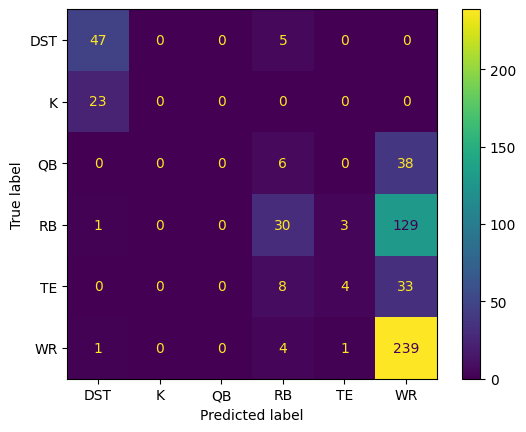

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_raw = model.predict(X_test)
y_pred = np.argmax(y_pred_raw, axis=-1)

cm = confusion_matrix(y_test_encoded.argmax(axis=1), y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()


### Random Forest Model

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(team_1_inputs, team_1_outputs, test_size=0.3, random_state=42)

encoder = LabelEncoder()
outputs_train_encoded = encoder.fit_transform(outputs_train)
outputs_test_encoded = encoder.transform(outputs_test)

cv = KFold(n_splits=10, random_state=1, shuffle=True)

class_weights = {encoder.transform(['QB'])[0]: 4, 
                 encoder.transform(['TE'])[0]: 5}

model = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
# model = RandomForestClassifier(n_estimators=100, random_state=42)

scores = cross_val_score(model, inputs_train, outputs_train_encoded, scoring='accuracy', cv=cv, n_jobs=-1)

print('CV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

model.fit(inputs_train, outputs_train_encoded)

test_accuracy = model.score(inputs_test, outputs_test_encoded)

print(f'Test Accuracy: {test_accuracy}')

probabilities = model.predict_proba(inputs_test)

top_two_pred = np.argsort(probabilities, axis=1)[:, -2:]

correct = [y in pred for y, pred in zip(outputs_test_encoded, top_two_pred)]
accuracy = np.mean(correct)

print(f'Top-2 accuracy: {accuracy * 100:.2f}%')

CV Accuracy: 0.624 (0.031)
Test Accuracy: 0.6468531468531469
Top-2 accuracy: 90.91%


CV Accuracy: 0.592 (0.010)

Test Accuracy: 0.6131964809384164

Top-2 accuracy: 86.17%

Accuracy for class 'DST': 80.77%

Accuracy for class 'K': 52.17%

Accuracy for class 'QB': 40.91%

Accuracy for class 'RB': 57.06%

Accuracy for class 'TE': 35.56%

Accuracy for class 'WR': 76.73%

Accuracy for class 'DST': 80.77%
Accuracy for class 'K': 52.17%
Accuracy for class 'QB': 40.91%
Accuracy for class 'RB': 57.67%
Accuracy for class 'TE': 33.33%
Accuracy for class 'WR': 77.14%


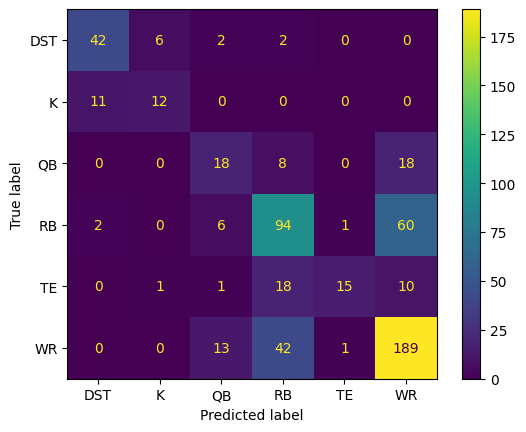

In [99]:

test_predictions = model.predict(inputs_test)
cm = confusion_matrix(outputs_test_encoded, test_predictions)
total_per_class = np.sum(cm, axis=1)
correct_per_class = np.diag(cm)
accuracy_per_class = correct_per_class / total_per_class * 100

for i, class_label in enumerate(encoder.classes_):
    print(f"Accuracy for class '{class_label}': {accuracy_per_class[i]:.2f}%")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='viridis')

plt.show()

In [100]:
misclassified_top_two_counts = {label: 0 for label in encoder.classes_}

misclassified_counts = {label: 0 for label in encoder.classes_}

predicted_classes = model.predict(inputs_test)

for true_class, pred_class, pred in zip(outputs_test_encoded, predicted_classes, top_two_pred):
    if true_class != pred_class:
        class_label = encoder.inverse_transform([true_class])[0]
        misclassified_counts[class_label] += 1
        if true_class in pred:
            misclassified_top_two_counts[class_label] += 1

top_two_percentages = {label: (misclassified_top_two_counts[label] / misclassified_counts[label]) * 100 if misclassified_counts[label] > 0 else 0 for label in encoder.classes_}

for class_label, percentage in top_two_percentages.items():
    print(f"Percentage of times misclassified class '{class_label}' is in the top 2 predictions: {percentage:.2f}%")

Percentage of times misclassified class 'DST' is in the top 2 predictions: 70.00%
Percentage of times misclassified class 'K' is in the top 2 predictions: 100.00%
Percentage of times misclassified class 'QB' is in the top 2 predictions: 42.31%
Percentage of times misclassified class 'RB' is in the top 2 predictions: 81.16%
Percentage of times misclassified class 'TE' is in the top 2 predictions: 60.00%
Percentage of times misclassified class 'WR' is in the top 2 predictions: 83.93%


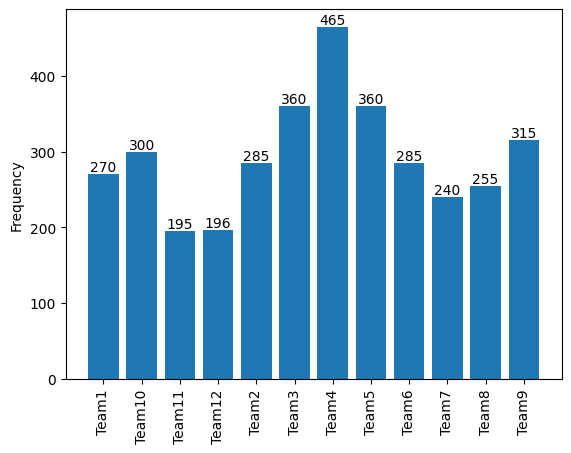

In [28]:

batch1_best_team_distribution = np.load('batch1_12_PPR_15/best_teams.npy')

unique_values, counts = np.unique(batch1_best_team_distribution, return_counts=True)

plt.bar(unique_values, counts)

for i, count in enumerate(counts):
    plt.text(unique_values[i], count, str(count), ha='center', va='bottom')

plt.ylabel('Frequency')

plt.xticks(rotation=90)

plt.show()